<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/fitaovana/Gibbs_sampling_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, poisson

In [0]:
# fix the random seed for replicability.
np.random.seed(123456789)

# Generate data

# Hyperparameters
N=50
a=2


In [0]:
# Change-point: where the intensity parameter changes.
n=int(round(uniform.rvs()*N))
str(n)

'27'

In [0]:
# Intensity values
lambda1=gamma.rvs(a) # We use 1/b instead of b because of the way Gamma distribution is parametrized in the package random.
lambda2=gamma.rvs(a)

lambdas=[lambda1]*n
lambdas[n:N]=[lambda2]*(N-n)
tap = np.array([lambda1]*n)
print(tap.shape)
print(np.array(lambdas[n:N]).shape)
print(lambdas)

(27,)
(23,)
[4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 4.074274524634351, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745, 10.866597768366745]


In [0]:
# Observations, x_1 ... x_N
x=poisson.rvs(lambdas)
print(x) # for each simulation, x displays a list of N simulated values)
x.shape

[ 8  0  1  5  4  4  9  3  5  5  4  1  3  6  3  2  3  2  4  4  4  6  4  4
  7  4  5  7  7 16 12 17 10  8 12 15 10 10  8  9 10 14 10  9  9 15 11 13
 10  8]


(50,)

In [0]:
for i in range(N-1):
  cvx = x[0:i+1]
  dfc = sum(x[0:i+1])
  print(cvx)
  print(dfc)

In [0]:
for i in range(N-1):
  cvd = x[i+1:N]
  dfd = sum(x[i+1:N])
  print(cvd)
  print(dfd)

In [0]:
# Gibbs sampler
E=5200
BURN_IN=200

# Initialize the chain
n=int(round(uniform.rvs()*N))
#lambda1=gamma.rvs(a,1/b)
#lambda2=gamma.rvs(a,1/b)

# Store the samples
chain_n=np.array([0.]*(E-BURN_IN))
chain_lambda1=np.array([0.]*(E-BURN_IN))
chain_lambda2=np.array([0.]*(E-BURN_IN))

for e in range(E):
	#print("At iteration ",str(e))
	# sample lambda1 and lambda2 from their posterior conditionals, Equation 8 and Equation 9, respectively.
	lambda1= gamma.rvs(a+sum(x[0:n]))/n
	lambda2= gamma.rvs(a+sum(x[n:N]))/(N-n)
	
	# sample n, Equation 10
	mult_n=np.array([0]*(N-1))
	for i in range(N-1):
		mult_n[i]=sum(x[0:i+1])*log(lambda1)-(i+1)*lambda1 + sum(x[i+1:N])*log(lambda2) - (N-i-1)*lambda2
	multe_n=exp(mult_n -max(mult_n))
	n= np.where(np.random.multinomial(1,multe_n/sum(multe_n),size=1)==1)[1][0]+1
	
	# store
	if e>=BURN_IN:
		chain_n[e-BURN_IN]=n
		chain_lambda1[e-BURN_IN]=lambda1
		chain_lambda2[e-BURN_IN]=lambda2

In [0]:
lbda1= gamma.rvs(a+sum(x[0:27]), 1/(27+b))
lbda2= gamma.rvs(a+sum(x[27:N]), 1/(N-27+b))
print(lbda1)
print(lbda2)

131.18956334208352
274.9775837925132


In [0]:
print('lambda1 =', lambda1)
print('lambda2 =', lambda2)
print(sum(x[0:1])*log(lambda1)-lambda1+sum(x[1:N])*log(lambda2)-(N-1)*lambda2)
print('chain_lambda1 =', chain_lambda1)
print('chain_lambda2 =', chain_lambda2)

print('mult_n =', mult_n)
print('mult_n[26]=', mult_n[26])
print('mult_n[0]=',mult_n[0])
print(mult_n.shape)
print(multe_n)
print(sum(multe_n))
print(np.where(np.random.multinomial(1,multe_n/sum(multe_n),size=1) == 1))

print(chain_n.shape)
print(chain_n)

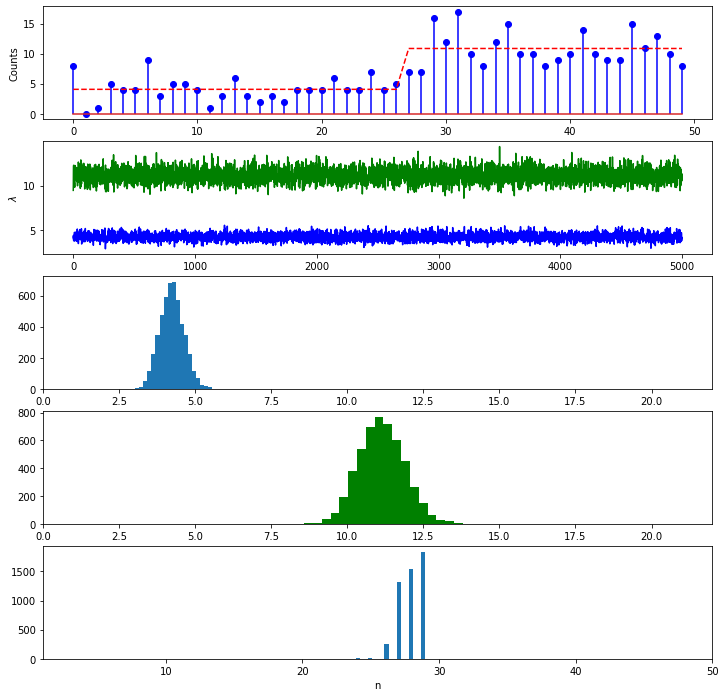

In [0]:
# make one big subplots and put everything in it.
f, (ax1,ax2,ax3,ax4,ax5)=plt.subplots(5,1, figsize=(12, 12))
# Plot the data
ax1.stem(range(N),x,linefmt='b-', markerfmt='bo',use_line_collection=True)
ax1.plot(range(N),lambdas,'r--')
ax1.set_ylabel('Counts')

ax2.plot(chain_lambda1,'b',chain_lambda2,'g')
ax2.set_ylabel('$\lambda$')

ax3.hist(chain_lambda1,20)
ax3.set_xlabel('$\lambda_1$')
ax3.set_xlim([0,22])

ax4.hist(chain_lambda2,20,color='g')
ax4.set_xlim([0,22])
ax4.set_xlabel('$\lambda_2$')

ax5.hist(chain_n,20)
ax5.set_xlabel('n')
ax5.set_xlim([1,50])
plt.show()